Importamos las librerias requeridas

In [1]:
import os
import pandas as pd
import boto3
import pickle
import matplotlib.pyplot as plt
import plotly.express as px
import nbformat
from dotenv import load_dotenv
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


Traemos toda la informacion

In [12]:

# Configurar la conexión con S3 usando variables de entorno
load_dotenv()
s3_client = boto3.client(
    's3',
    aws_access_key_id=os.getenv('Access_key_ID'),
    aws_secret_access_key=os.getenv('Secret_access_key')
)

bucket_name = 'chicago-inspections-analytics'
folder_prefix = 'datos_limpios/datos_limpios/'  # Ruta de la carpeta en S3

# Función para listar todos los archivos en el directorio de S3
def listar_archivos_s3(bucket_name, prefix):
    try:
        response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
        if 'Contents' in response:
            return [obj['Key'] for obj in response['Contents'] if obj['Key'].endswith('.pkl')]
        return []
    except Exception as e:
        print("Error al listar archivos en S3:", e)
        return []

# Función para cargar y concatenar todos los archivos `.pkl`
def cargar_y_concatenar_pkl(bucket_name, file_keys):
    dfs = []
    for key in file_keys:
        try:
            # Descargar el archivo de S3
            file_obj = s3_client.get_object(Bucket=bucket_name, Key=key)
            file_data = file_obj['Body'].read()
            
            # Convertir el archivo de Pickle a un DataFrame
            df = pickle.loads(file_data)
            dfs.append(df)
            print(f"Archivo {key} cargado exitosamente.")
        except Exception as e:
            print(f"Error al cargar el archivo {key}:", e)
    
    # Concatenar todos los DataFrames
    if dfs:
        df_concatenado = pd.concat(dfs, ignore_index=True)
        print("Todos los archivos concatenados exitosamente.")
        return df_concatenado
    else:
        print("No se cargaron archivos para concatenar.")
        return None

# Obtener la lista de archivos `.pkl` en el directorio
file_keys = listar_archivos_s3(bucket_name, folder_prefix)

# Cargar y concatenar los archivos
df_concatenado = cargar_y_concatenar_pkl(bucket_name, file_keys)

# Mostrar información del DataFrame concatenado
if df_concatenado is not None:
    fecha_mas_reciente = df_concatenado['inspection_date'].max()
    print("Fecha más reciente en el DataFrame:", fecha_mas_reciente)
else:
    print("No se pudo concatenar ningún archivo.")


Archivo datos_limpios/datos_limpios/datos_limpios_2024-11-13_0137e891ac0ba69eb445dce8c35e69c9.pkl cargado exitosamente.
Archivo datos_limpios/datos_limpios/datos_limpios_2024-11-13_08e32f34859ab66384461bbea8b811ce.pkl cargado exitosamente.
Archivo datos_limpios/datos_limpios/datos_limpios_2024-11-13_1f9f76866c76400794f16f4e2ecb9425.pkl cargado exitosamente.
Archivo datos_limpios/datos_limpios/datos_limpios_2024-11-13_2d79ff39b57b328e439f8819fb602c28.pkl cargado exitosamente.
Archivo datos_limpios/datos_limpios/datos_limpios_2024-11-13_3243837baa4e60f0dc2f7ec92acc877b.pkl cargado exitosamente.
Archivo datos_limpios/datos_limpios/datos_limpios_2024-11-13_3a017faf5b387ee5f2f3455b509fb78f.pkl cargado exitosamente.
Archivo datos_limpios/datos_limpios/datos_limpios_2024-11-13_3ac8109d27868b3f24d81321f56d33e6.pkl cargado exitosamente.
Archivo datos_limpios/datos_limpios/datos_limpios_2024-11-13_3d14e1f3e36ef06769bc4476dab360a2.pkl cargado exitosamente.
Archivo datos_limpios/datos_limpios/dato

TypeError: '>=' not supported between instances of 'Timestamp' and 'str'

In [13]:
df_concatenado['results'].value_counts()

results
Pass                    143606
Fail                     54394
Pass w/ Conditions       42399
Out of Business          23489
No Entry                 11611
Not Ready                 3650
Business Not Located        87
Name: count, dtype: int64

De acuerdo a la logica que tengo en este momento considero que las features que impactan mas en el resultado de una inspeccion son:
1.- risk
2.-facilit_type
3.-violations
4.-inspection_type
5.-latitude
6.-longitude
en este momento no trataremos violations debido a que deberiamos llamar a un llm, en etapas posteriores veremos como tratar esto
retiramos violations


conservemos solo columnas aparentemente relevantes

In [ ]:
# Lista de columnas que deseas conservar
columnas_a_conservar = ['facility_type', 'risk', 'inspection_type','latitude','longitude','results']
# Convertir la columna objetivo en valores numéricos si es categórica
# Crear un nuevo DataFrame con solo las columnas especificadas
df_filtered = df_concatenado[columnas_a_conservar]


procedemos a convertir las columnas risk facility_type inspection_type y results a numeros

In [9]:

# Lista de columnas categóricas a convertir
categorical_columns = ['facility_type', 'risk', 'inspection_type', 'results']

# Diccionario para guardar los mapeos
mappings = {}

# Convertir columnas categóricas a numéricas basadas en frecuencia
for column in categorical_columns:
    if column == 'results':  # Mapear 'results' manualmente
        df_filtered[column] = df_filtered[column].map({'Pass': 0, 'Fail': 1,'Pass w/ Conditions':0,'Out of Business':1,'No Entry':1,'Not Ready':1,'Business Not Located':1})
        mappings[column] = {'Pass': 0, 'Fail': 1}
    else:  # Mapear dinámicamente basado en frecuencia
        counts = df_filtered[column].value_counts()  # Ordenar categorías por frecuencia
        mapping = {category: idx for idx, category in enumerate(counts.index)}
        df_filtered[column] = df_filtered[column].map(mapping)
        mappings[column] = mapping

# Mostrar el DataFrame convertido
print("DataFrame Convertido:")
print(df_filtered)

# Mostrar los mapeos guardados
print("\nMapeos Guardados:")
for column, mapping in mappings.items():
    print(f"{column}: {mapping}")

DataFrame Convertido:
        facility_type  risk  inspection_type   latitude  longitude  results
0                   0     1             11.0  41.884586 -87.631010        0
1                   0     0              4.0  41.961606 -87.675967        0
2                   0     0              4.0  41.961606 -87.675967        0
3                   0     0              0.0  41.898431 -87.628009        1
5                   0     0              4.0  41.938443 -87.768318        0
...               ...   ...              ...        ...        ...      ...
247649              1     2              5.0  41.894759 -87.763322        0
247650             12     0              2.0  41.778215 -87.633464        0
247651              0     0              1.0  41.722565 -87.576429        0
247652              0     1              0.0  41.954376 -87.688623        0
247653              0     0              0.0  42.002377 -87.815748        0

[246799 rows x 6 columns]

Mapeos Guardados:
facility_type: {'Res

C:\Users\PC\AppData\Local\Temp\ipykernel_1864\3474507416.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[column] = df_filtered[column].map(mapping)
C:\Users\PC\AppData\Local\Temp\ipykernel_1864\3474507416.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[column] = df_filtered[column].map(mapping)
C:\Users\PC\AppData\Local\Temp\ipykernel_1864\3474507416.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

Comenzamos a hacer la correlacion

Correlación con 'results':
results            1.000000
risk               0.105933
facility_type      0.009931
longitude         -0.000762
latitude          -0.003994
inspection_type   -0.083686
Name: results, dtype: float64


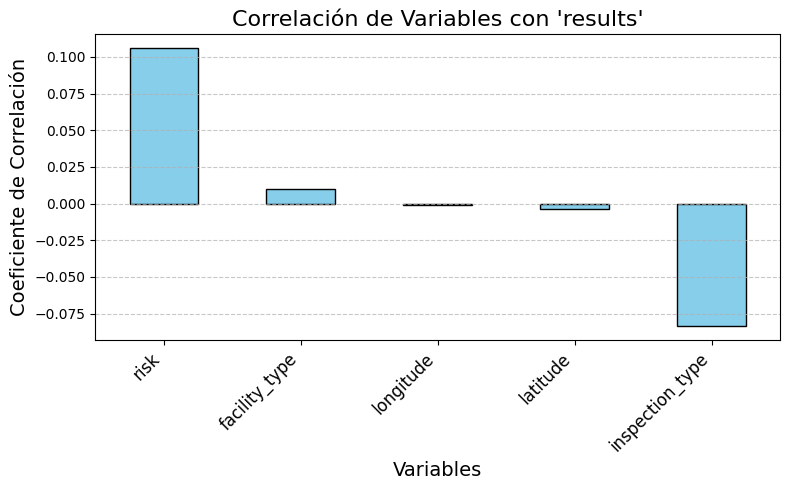

In [11]:
# Calcular la correlación de todas las columnas con 'results'
correlation_with_results = df_filtered.corr()['results'].sort_values(ascending=False)

# Mostrar las correlaciones
print("Correlación con 'results':")
print(correlation_with_results)

# Visualizar la correlación con un gráfico de barras
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
correlation_with_results.drop('results').plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Correlación de Variables con 'results'", fontsize=16)
plt.ylabel("Coeficiente de Correlación", fontsize=14)
plt.xlabel("Variables", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


La correlación de las variables con results es muy baja en general, lo que sugiere que estas características por sí solas no explican bien los resultados (Pass o Fail).
Interpretación de las Correlaciones
Variables con Correlación Positiva:
risk (0.105933):

Aunque tiene la correlación más alta con results, el valor sigue siendo bajo, indicando una relación débil.
Puede ser útil en combinación con otras características.
facility_type (0.009931):

Correlación casi nula, probablemente no es una variable predictiva significativa.
Variables con Correlación Negativa:
inspection_type (-0.083686):

Aunque la correlación es negativa, sigue siendo débil. Podría haber una ligera tendencia en ciertos tipos de inspecciones.
longitude (-0.000762) y latitude (-0.003994):

Estas variables prácticamente no tienen relación lineal con los resultados.


Dado que las correlaciones individuales son bajas, esto indica que:

Las relaciones pueden no ser lineales.

Algoritmos como Random Forest son adecuados porque capturan interacciones y no suponen relaciones lineales.
Combinaciones de variables podrían ser más útiles.

Por ejemplo, combinar risk y inspection_type para crear nuevas características.
Evaluar la importancia de características con el modelo.

Aunque las correlaciones son bajas, Random Forest puede identificar características que son importantes en combinación.

In [174]:
print(df_filtered['results'].isnull().sum())


0


In [175]:
X = df_filtered.drop(columns=['results'])  # Todas las columnas excepto 'results'
y = df_filtered['results']  # Variable objetivo

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)



evaluar con grid search

In [ ]:
# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],  # Número de árboles
    'max_depth': [10, 20, None],     # Profundidad máxima
    'min_samples_split': [2, 5, 10], # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],   # Mínimo de muestras en las hojas
    'class_weight': [None, 'balanced']  # Ajustar pesos para manejar desbalance
}

# Configurar el modelo
rf = RandomForestClassifier(random_state=42)

# Configurar el GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,  # Validación cruzada con 3 divisiones
    scoring='f1',  # Optimizar F1-score para equilibrar precisión y recall
    verbose=2,
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Ejecutar la búsqueda en el conjunto de entrenamiento
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print("Mejores Parámetros Encontrados:")
print(grid_search.best_params_)

# Evaluar el modelo con los mejores parámetros
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Precisión del modelo
print(f"\nPrecisión del Modelo Optimizado: {accuracy_score(y_test, y_pred) * 100:.2f}%")

Fitting 3 folds for each of 162 candidates, totalling 486 fits


In [176]:
# Entrenar el modelo Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [177]:
y_pred = rf.predict(X_test)


In [178]:
# Evaluación del modelo
print("Matriz de Confusión:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

print("\nPrecisión del Modelo:")
print(f"{accuracy_score(y_test, y_pred) * 100:.2f}%")


Matriz de Confusión:
[[40312  8950]
 [14150  9882]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.74      0.82      0.78     49262
           1       0.52      0.41      0.46     24032

    accuracy                           0.68     73294
   macro avg       0.63      0.61      0.62     73294
weighted avg       0.67      0.68      0.67     73294


Precisión del Modelo:
68.48%


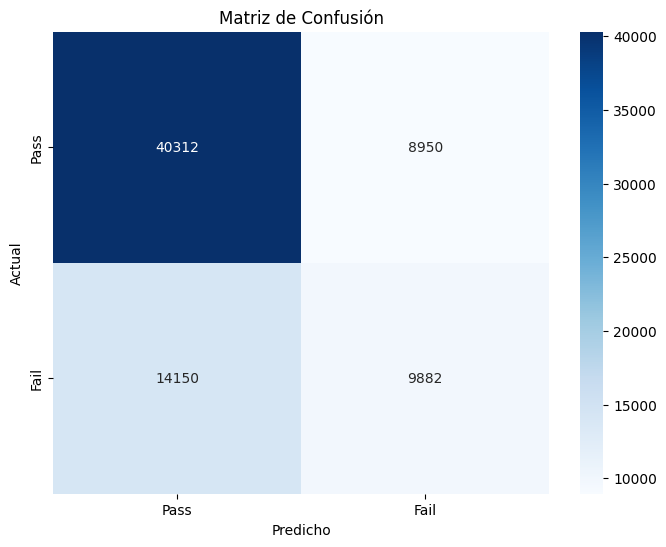

In [179]:
# Visualizar la Matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Pass", "Fail"], yticklabels=["Pass", "Fail"])
plt.title("Matriz de Confusión")
plt.ylabel("Actual")
plt.xlabel("Predicho")
plt.show()

In [180]:
# Importancia de las Características
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nImportancia de las Características:")
print(feature_importances)


Importancia de las Características:
           Feature  Importance
3         latitude    0.377586
4        longitude    0.374294
2  inspection_type    0.164447
0    facility_type    0.050458
1             risk    0.033215


C:\Users\PC\AppData\Local\Temp\ipykernel_21264\3182524753.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette="viridis")


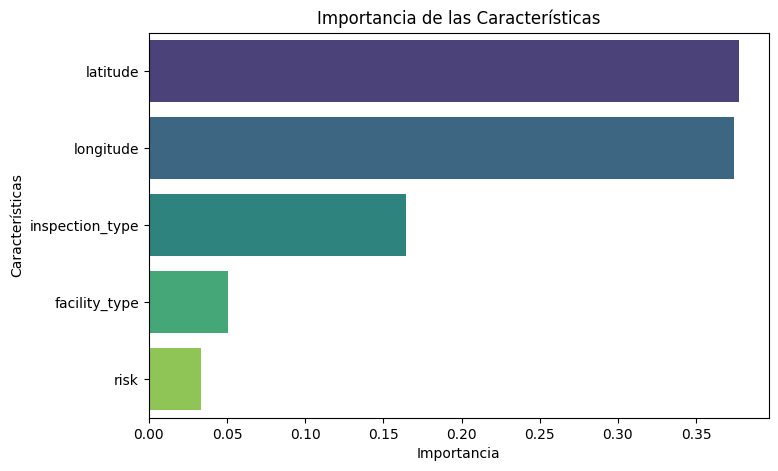

In [181]:
# Visualizar Importancia de las Características
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette="viridis")
plt.title("Importancia de las Características")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.show()